In [1]:
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass

In [2]:
# Cryptarchia lottery function
def phi(f, alpha):
    return 1 - (1-f)**alpha

evaluations = 100

# sim params
@dataclass
class Params:
    epochs: int
    sims: int
    stake: np.array
    T: int
    f: float
    beta: float
    D_init: float

    @property
    def h_at_fixpoint(self):
        D_inf = gauss_field_mean(f=self.f, stake=self.stake)
        return D_inf / np.log(1/(1-self.f)) * self.beta
    
    def __str__(self):
        import dataclasses
        """Returns a string containing only the non-default field values."""
        s = ', '.join(f'{field.name}={getattr(self, field.name)!r}'
                      for field in dataclasses.fields(self)
                      if field.name != "stake")
        s += f", stake=(N={len(self.stake)}, mean={self.stake.mean():.2f}, var={self.stake.var():.2f})"
        return f'{type(self).__name__}({s})'

In [3]:
# Generate stake distribution
def make_params(i):
    np.random.seed(0)
    N = 100
    stake = np.random.uniform(0, 1, N) ** (i*2+1)
    return Params(
        epochs=100,
        sims=10,
        stake = stake,
        D_init = stake.sum(),
        T=int(10 * 2160 / (1/30)),
        f=(1/30),
        beta=0.8,
    )

vary_stake_params = [make_params(i) for i in range(evaluations)]

In [4]:
ratios = []
for j in range(evaluations):
    vsp = vary_stake_params[j]
    D_values_j = []
    
    # Initial stake estimate 
    D_ell = vsp.D_init * 0.75
    
    for i in range(0, vsp.epochs):
    
        # Running one epoch of the cryptarchia lottery
        alpha = vsp.stake / D_ell
        p_lottery = phi(vsp.f, alpha)
        wins = np.random.uniform(0, 1, (vsp.T, len(vsp.stake))) < p_lottery
    
        # Total Stake Inference
        empirical_slot_activation_rate = (wins.sum(axis=1) != 0).sum() / vsp.T
        error = vsp.f - empirical_slot_activation_rate
    
        # Learning coefficient
        h = vsp.beta * (D_ell / vsp.f)
    
        # New total stake estimate
        D_ell = D_ell - h * error
        D_values_j.append(D_ell)
            
    ratios.append(np.mean(D_values_j[-10:] / np.full_like(range(0, 10), vsp.D_init, dtype=float)))
    print(ratios[j])

1.0023676874989447
1.0021728136582488
0.9989441779606686
1.003955035311425
0.9979128359075979
0.9967952390649157
1.0001131994785077
0.99866810490959
0.9995305561970589
0.9997020400432076
1.0028640464671794
0.995343753465011
1.0036888790103764
1.0039446357780037
1.002557224168902
1.0003009698995637
0.9966325192773976
0.999436155646863
1.0011055293050062
1.0012279020800763
0.9990862424911157
0.997983883190692
1.0056627472828505
1.0006951489102047
1.001951867753856
0.9995214922046258
1.0013051452681387
1.0001817762795295
1.001608577673848
1.0038323848688284
1.0029932115677838
1.0003573361376639
1.003303592256525
1.0012569341316524
1.0018154781780149
1.0010950688825906
0.9996986603721826
1.000756095178297
0.9995523752140102
1.003774673701196
1.0003575532958902
1.0012981753073091
0.9978712655730252
1.003281264794399
0.9991788422690455
1.0011078223742378
1.0020954816178498
1.000739932296818
0.9988078306842825
0.9968900678807892
1.000864844322923
0.9998740756506
0.9980890735520648
1.002656619

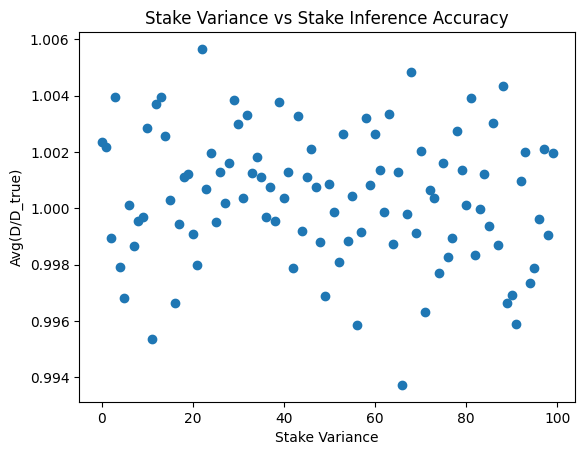

In [6]:
plt.scatter(range(0, evaluations), ratios)
plt.xlabel("Stake Variance")
plt.ylabel("Avg(D/D_true)")
plt.title("Stake Variance vs Stake Inference Accuracy")
plt.show()